In [36]:
import os
import sys
from collections import defaultdict

import zipfile
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
import torch
from torch import optim
from torch import nn
from scipy.stats import kendalltau, spearmanr
from IPython.display import clear_output
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

np.set_printoptions(precision=4, suppress=True)

In [29]:
if not os.path.exists('/content/chgk.zip'):
    !rm -rf chgk.zip
    !wget -q https://www.dropbox.com/s/s4qj0fpsn378m2i/chgk.zip
    !unzip -oq chgk.zip

In [10]:
players_dict = pd.read_pickle('/content/players.pkl')
players_df = pd.DataFrame.from_dict(players_dict, orient='index')
players_df.head()

,id,name,patronymic,surname
1,1,Алексей,None,Абабилов
10,10,Игорь,,Абалов
11,11,Наталья,Юрьевна,Абалымова
12,12,Артур,Евгеньевич,Абальян
13,13,Эрик,Евгеньевич,Абальян


In [11]:
tournaments_dict = pd.read_pickle('/content/tournaments.pkl')
tournaments_df = pd.DataFrame.from_dict(tournaments_dict, orient='index')
tournaments_df.head()

,id,name,dateStart,dateEnd,type,season,orgcommittee,synchData,questionQty
1,1,Чемпионат Южного Кавказа,2003-07-25T00:00:00+04:00,2003-07-27T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
2,2,Летние зори,2003-08-09T00:00:00+04:00,2003-08-09T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/1,[],None,None
3,3,Турнир в Ижевске,2003-11-22T00:00:00+03:00,2003-11-24T00:00:00+03:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
4,4,Чемпионат Украины. Переходной этап,2003-10-11T00:00:00+04:00,2003-10-12T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None
5,5,Бостонское чаепитие,2003-10-10T00:00:00+04:00,2003-10-13T00:00:00+04:00,"{'id': 2, 'name': 'Обычный'}",/seasons/2,[],None,None


In [12]:
results = pd.read_pickle('/content/results.pkl')

Строим тренировочный и тестовый датасеты

In [13]:
def build_dataset(year_list: list, is_train: bool = True) -> dict:
        dataset_dict = defaultdict(list)
        team_bad_mask_list = []
        
        for year in year_list:
            tournaments_year = tournaments_df[tournaments_df['dateStart'].str.startswith(year)]
            for _id in tournaments_year['id']:
                for team_result in results[_id]:
                    
                    question_total_count = sum(tournaments_year.at[_id, 'questionQty'].values())
                    mask = team_result.get('mask', None)
                    
                    if mask:
                        if len(mask) == question_total_count or not is_train:
                            for player in team_result['teamMembers']:
                                dataset_dict[_id].append({
                                    'tournament_id': _id,
                                    'tournament_name': tournaments_year.at[_id, 'name'],
                                    'team_id': team_result['team']['id'],
                                    'team_name': team_result['team']['name'],
                                    'mask': team_result['mask'],
                                    'position': team_result['position'],
                                    'player_id': player['player']['id'],
                                    'player_name': player['player']['name'] + ' ' + \
                                                    player['player']['surname']

                                })
                        else:
                            team_bad_mask_list.append(team_result['team']['id'])
        
        if is_train:
            print(
                f'Number of teams in train with bad mask: {len(set(team_bad_mask_list))}',
                file=sys.stderr
            )
                
        return dataset_dict

In [14]:
train = build_dataset(['2019'])
test = build_dataset(['2020'], is_train=False)

print(f'Unique tournaments in train: {len(train)}')
print(f'Unique tournaments in test: {len(test)}')

Number of teams in train with bad mask: 4047


Unique tournaments in train: 675
Unique tournaments in test: 173


In [15]:
df_train = pd.DataFrame([x for v in train.values() for x in v])
df_test = pd.DataFrame([x for v in test.values() for x in v])

df_train.shape, df_test.shape

((414743, 8), (112841, 8))

In [16]:
df_train.head()

,tournament_id,tournament_name,team_id,team_name,mask,position,player_id,player_name
0,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,1.0,6212,Юрий Выменец
1,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,1.0,18332,Александр Либер
2,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,1.0,18036,Михаил Левандовский
3,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,1.0,22799,Сергей Николенко
4,4772,Синхрон северных стран. Зимний выпуск,45556,Рабочее название,111111111011111110111111111100010010,1.0,15456,Сергей Коновалов


In [17]:
del results
del train
del test

In [42]:
qa_dataset_dict = defaultdict(list)

for row in df_train[['tournament_id', 'team_id', 'player_id', 'mask']].itertuples():
    for index, mask_value in enumerate(row.mask):
        if mask_value not in ['X', '?']:
            qa_dataset_dict['question_id'].append(f'{row.tournament_id}_{index}')
            qa_dataset_dict['tournament_id'].append(row.tournament_id)
            qa_dataset_dict['team_id'].append(row.team_id)
            qa_dataset_dict['player_id'].append(row.player_id)
            qa_dataset_dict['answer'].append(mask_value)
            
qa_dataset_df = pd.DataFrame(qa_dataset_dict).astype(dtype={'answer': np.uint8})

In [43]:
qa_dataset_df.head()

,question_id,tournament_id,team_id,player_id,answer
0,4772_0,4772,45556,6212,1
1,4772_1,4772,45556,6212,1
2,4772_2,4772,45556,6212,1
3,4772_3,4772,45556,6212,1
4,4772_4,4772,45556,6212,1


# Часть 2

Постройте baseline-модель на основе линейной или логистической регрессии, которая будет обучать рейтинг-лист игроков. Замечания и подсказки:
* повопросные результаты — это фактически результаты броска монетки, и их предсказание скорее всего имеет отношение к бинарной классификации;
* в разных турнирах вопросы совсем разного уровня сложности, поэтому модель должна это учитывать; скорее всего, модель должна будет явно обучать не только силу каждого игрока, но и сложность каждого вопроса;
* для baseline-модели можно забыть о командах и считать, что повопросные результаты команды просто относятся к каждому из её игроков.
-----

Предположения:
* если команда ответила на вопрос, то каждый игрок команды ответил на данный вопрос.

In [20]:
encoder = OneHotEncoder()

X_train = encoder.fit_transform(qa_dataset_df[['question_id', 'player_id']])

In [21]:
class LogRegression(nn.Module):
    def __init__(self, n_features):
        super(LogRegression, self).__init__()
        self.linear = nn.Linear(n_features, 1)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        x = self.linear(x)
        out = self.sigmoid(x)
        return out

In [25]:
def m_step(model, x, y_true, lr=1e-4, n_iter=100):
    model.linear.reset_parameters()
    criterion = nn.BCELoss()
    opt = optim.Adam(model.parameters(), lr)
    
    for i in tqdm(range(n_iter)):
        opt.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y_true)
        loss.backward()
        opt.step()

In [23]:
X_train = X_train.tocoo()

x = torch.sparse.FloatTensor(
    torch.LongTensor(np.vstack((X_train.row, X_train.col))),
    torch.FloatTensor(X_train.data)
)

y = torch.FloatTensor(qa_dataset_df['answer'].values).view(-1, 1)

model = LogRegression(x.shape[1])

In [26]:
m_step(model, x, y, lr=1)

Результаты ранжирования:

In [27]:
player_skill_dict = defaultdict(list)

for i, feature_name in enumerate(encoder.get_feature_names()):
    feature_prefix, _id = feature_name.split('_', 1)
    if feature_prefix == 'x1':
        player_skill_dict['player_id'].append(int(_id))
        player_skill_dict['skill'].append(model.linear.weight.data[0].numpy()[i])
        player_skill_dict['name'].append(players_df.at[int(_id), 'name'])
        player_skill_dict['surname'].append(players_df.at[int(_id), 'surname'])
        
player_skill_df = pd.DataFrame(player_skill_dict)
player_skill_df.sort_values(by='skill', inplace=True, ascending=False, ignore_index=True)
player_skill_df.reset_index(inplace=True)
player_skill_df.rename(columns={'index': 'place'}, inplace=True)
player_skill_df['place'] += 1

In [28]:
player_skill_df.head(20)

,place,player_id,skill,name,surname
0,1,27403,3.373929,Максим,Руссо
1,2,4270,3.234975,Александра,Брутер
2,3,28751,3.186349,Иван,Семушин
3,4,27822,3.110051,Михаил,Савченков
4,5,30270,3.032629,Сергей,Спешков
5,6,30152,3.025037,Артём,Сорожкин
6,7,40411,3.020087,Дмитрий,Кудинов
7,8,38175,2.954801,Максим,Пилипенко
8,9,20691,2.924137,Станислав,Мереминский
9,10,202410,2.877939,Валентина,Подюкова


Сравним результаты ранжирования с реальным рейтингом игроков на 26 декабря 2019 года:

In [30]:
real_player_skill_df = pd.read_csv(f'{DATA_FPATH}/players-release-2019-12-26.csv')

real_player_skill_df = real_player_skill_df[[' ИД', 'Место']].rename(
    columns={' ИД': 'player_id', 'Место': 'real_place'}
)


player_skill_df.join(real_player_skill_df.set_index('player_id'), on='player_id') \
    .fillna(-1) \
    .astype(dtype={'real_place': np.uint32}) \
    .head(20)

,place,player_id,skill,name,surname,real_place
0,1,27403,3.373929,Максим,Руссо,5
1,2,4270,3.234975,Александра,Брутер,6
2,3,28751,3.186349,Иван,Семушин,2
3,4,27822,3.110051,Михаил,Савченков,3
4,5,30270,3.032629,Сергей,Спешков,4
5,6,30152,3.025037,Артём,Сорожкин,1
6,7,40411,3.020087,Дмитрий,Кудинов,6879
7,8,38175,2.954801,Максим,Пилипенко,11063
8,9,20691,2.924137,Станислав,Мереминский,171
9,10,202410,2.877939,Валентина,Подюкова,4294967295


# Часть 3

Качество рейтинг-системы оценивается качеством предсказаний результатов турниров. Но сами повопросные результаты наши модели предсказывать вряд ли смогут, ведь неизвестно, насколько сложными окажутся вопросы в будущих турнирах; да и не нужны эти предсказания сами по себе. Поэтому:
 * предложите способ предсказать результаты нового турнира с известными составами, но неизвестными вопросами, в виде ранжирования команд;
 * в качестве метрики качества на тестовом наборе давайте считать ранговые корреляции Спирмена и Кендалла (их можно взять в пакете *scipy*) между реальным ранжированием в результатах турнира и предсказанным моделью, усреднённые по тестовому множеству турниров (для самопроверки: у меня средняя корреляция Спирмена на тестовом множестве 2020 года во всех моделях, включая baselines, получалась порядка 0.7-0.8, а корреляция Кендалла — порядка 0.5-0.6. Если у вас корреляции вышли за 0.9 или, наоборот, упали ниже 0.3, скорее всего где-то баг).
-----

Сила команды - вероятность, что хотя бы один игрок команды ответит на вопрос средней сложности:

$$\displaystyle t_i = 1 - \prod_{j=1}^{N}{(1 - \sigma(\mu + s_{ij} + q_{mean}))}$$

где:<br>
* $s_{ij}$ — сила игрока $j$ в команде $i$,
* $N$ — количество игроков в команде $i$,
* $q_{mean}$ — средняя сложность вопроса,
* $\mu$ — константа.

In [31]:
def calc_metrics(df, encoder, parameters, intercept):
    player_weights = {}
    count = 0
    question_sum = 0
    player_sum = 0
    player_cnt = 0
    for i, feature_name in enumerate(encoder.get_feature_names()):
        feature_prefix, _id = feature_name.split('_', 1)
        
        if feature_prefix == 'x1':
            player_weights[int(_id)] = parameters[i]
            player_sum += parameters[i]
            player_cnt += 1
        else:
            question_sum += parameters[i]
            count += 1
            
    question_mean = question_sum / count
    
    df["player_weights"] = df["player_id"].map(player_weights)
    df["player_weights"].fillna(player_sum / player_cnt, inplace=True)
    
    df["players_proba"] = df["player_weights"].apply(
        lambda x: 1 / (1 + np.exp(-(x + question_mean + intercept)))
    )
    
    probas = df.groupby(["tournament_id", "team_id"])["players_proba"].apply(
        lambda x: np.prod(1 - x)
    )
    
    position = df.groupby(["tournament_id", "team_id"])["position"].first()
    group_data = pd.concat([probas, position], axis=1)
    
    group_data.sort_values(
        ["tournament_id", "players_proba"],
        ascending=[True, True],
        inplace=True
    )
    
    spearman = group_data.groupby("tournament_id").apply(
        lambda x: spearmanr(x["position"], x["players_proba"]).correlation
    ).mean()
    
    kendall = group_data.groupby("tournament_id").apply(
        lambda x: kendalltau(x["position"], x["players_proba"]).correlation
    ).mean()
    
    return spearman, kendall

In [32]:
spearman, kendall = calc_metrics(
    df_test, 
    encoder,
    model.linear.weight.data[0].numpy(),
    model.linear.bias.data[0].numpy()
)

print(f"Spearman: {spearman:.6f}")
print(f"Kendall:  {kendall:.6f}")

Spearman: 0.785979
Kendall:  0.629128


# Часть 4

Теперь главное: ЧГК — это всё-таки командная игра. Поэтому:

* предложите способ учитывать то, что на вопрос отвечают сразу несколько игроков; скорее всего, понадобятся скрытые переменные; не стесняйтесь делать упрощающие предположения, но теперь переменные "игрок X ответил на вопрос Y" при условии данных должны стать зависимыми для игроков одной и той же команды;
* разработайте EM-схему для обучения этой модели, реализуйте её в коде;
* обучите несколько итераций, убедитесь, что целевые метрики со временем растут (скорее всего, ненамного, но расти должны), выберите лучшую модель, используя целевые метрики.
-----

Теорема Байеса в данном случае:

$$\displaystyle p(z_{ij}=1|t_i=1) = \frac{p(t_i=1|z_{ij}=1)p(z_{ij}=1)}{p(t_i=1)},$$

где:
* $p(z_{ij}=1|t_i=1)$ - вероятность того, что игрок $i$ ответил на вопрос $j$, при условии, что команда игрока $i$ ответила на этот вопрос
* $p(t_i=1|z_{ij}=1)$ - вероятность того, что команда игрока $i$ ответила на вопрос $j$, при условии, что игрок $i$ ответил на этот вопрос
* $p(z_{ij}=1)$ - вероятность того, что игрок $i$ ответил на вопрос $j$ (то, что получаем из М-шага)
* $p(t_i=1)$ - вероятность того, что команда игрока $i$ ответила на вопрос $j$

Предположения:
1. если хотя бы один из игроков команды ответил на вопрос, то и вся команда ответила на вопрос:
$$p(t_i=1|z_{ij}=1) = 1$$
2.  если команда не ответила на вопрос, то и все её члены не ответили на вопрос (игроки отвечают на вопрос независимо):
$$\displaystyle p(t_i=1) = 1 - \prod_{k=1}^{N}{(1 - \sigma(\mu + s_{ik} + q_{j}))}$$

Тогда:
$$\displaystyle p(z_{ij}=1|t_i=1) = \frac{\sigma(\mu + s_i + q_j)}{1 - \prod_{k=1}^{N}{(1 - \sigma(\mu + s_{ik} + q_{j}))}}$$

Реализуем E-шаг:

In [33]:
def e_step(df, m_step_output):
    df['target'] = m_step_output
    df.loc[df["answer"] == 0, "target"] = 0
    idx = df["answer"] == 1
    t = df.loc[idx].groupby(["team_id", "question_id"])["target"].transform(
        lambda x: 1 - np.prod(1 - x.values)
    )
    df.loc[idx, "target"] = df.loc[idx, "target"] / t  
    return df

Epoch: 10
    Spearman: 0.8033931688227448
    Kendall:  0.647979373690668


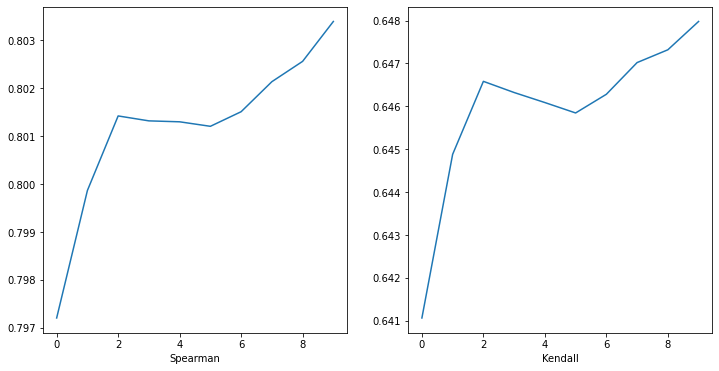

In [38]:
predictions = model(x).detach().numpy().ravel()

spearman_metric_list = []
kendall_metric_list = []

for i in tqdm(range(10)):
    qa_dataset_df = e_step(qa_dataset_df, predictions)
    y = torch.FloatTensor(qa_dataset_df["target"].values).view(-1, 1)
    m_step(model, x, y, lr=1, n_iter=100)
    torch.save(model.state_dict(), f"model_{i}.pth")
    predictions = model(x).detach().numpy().ravel()
    spearman, kendall = calc_metrics(df_test, encoder,
                                     model.linear.weight.data[0].numpy(),
                                     model.linear.bias.data[0].numpy())
    spearman_metric_list.append(spearman)
    kendall_metric_list.append(kendall)
    clear_output(True)
    print(f"Epoch: {i + 1}")
    print(f"    Spearman: {spearman}")
    print(f"    Kendall:  {kendall}")
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].plot(spearman_metric_list)
    ax[0].set_xlabel("Spearman")
    ax[1].plot(kendall_metric_list)
    ax[1].set_xlabel("Kendall")
    plt.show()

# Часть 5

А что там с вопросами? Постройте "рейтинг-лист" турниров по сложности вопросов. Соответствует ли он интуиции (например, на чемпионате мира в целом должны быть сложные вопросы, а на турнирах для школьников — простые)? *Если будет интересн*о: постройте топ сложных и простых вопросов со ссылками на конкретные записи в [базе вопросов ЧГК](http://db.chgk.info) (это чисто техническое дело, тут никакого ML нету).

-----
Предположение: сложность турнира - средняя сложность вопросов в нем


In [54]:
question_rating_dict = {}

for i, feature_name in enumerate(encoder.get_feature_names()):
    feature_prefix, _id = feature_name.split('_', 1)
    if feature_prefix == 'x0':
        question_rating_dict[_id] = model.linear.weight.data[0].numpy()[i]

tournament_weights_df = qa_dataset_df.groupby("tournament_id")["question_id"] \
    .apply(lambda x: -np.mean([question_rating_dict[y] for y in x])) \
    .sort_values(ascending=False) \
    .reset_index() \
    .rename(columns={'question_id': 'rating'})


In [55]:
tournament_weights_df.head()

,tournament_id,rating
0,6149,7.460022
1,5717,3.651457
2,5928,3.127630
3,5930,3.075409
4,5684,3.068610


In [59]:
tournament_difficulties_df = tournament_weights_df.merge(
    tournaments_df[["id", "name"]].set_index("id"),
    left_on="tournament_id", right_on="id",
)

In [62]:
tournament_difficulties_df.head(20)

,tournament_id,rating,name
0,6149,7.460022,Чемпионат Санкт-Петербурга. Первая лига
1,5717,3.651457,Чемпионат Таджикистана
2,5928,3.127630,Угрюмый Ёрш
3,5930,3.075409,Зеркало мемориала памяти Михаила Басса
4,5684,3.068610,Синхрон высшей лиги Москвы
5,6101,3.055812,Воображаемый музей
6,5943,2.901045,Чемпионат Мира. Этап 2 Группа С
7,5159,2.897119,Первенство правого полушария
8,5532,2.804678,Седьмая октава: Кубок Равноденствия. Лига Наци...
9,5942,2.741712,Чемпионат Мира. Этап 2. Группа В


In [63]:
tournament_difficulties_df.tail(20)

,tournament_id,rating,name
655,5702,-1.322163,(а)Синхрон-lite. Лига старта. Эпизод IX
656,5697,-1.331365,Школьный Синхрон-lite. Выпуск 3.1
657,5535,-1.354727,Кубок Тышкевичей
658,5601,-1.363366,Межфакультетский кубок МГУ. Отбор №4
659,6254,-1.385038,Школьная лига
660,5954,-1.451730,Школьная лига. II тур.
661,5012,-1.503898,Школьный Синхрон-lite. Выпуск 2.5
662,5013,-1.529751,(а)Синхрон-lite. Лига старта. Эпизод V
663,5388,-1.563197,Олимпиада Приволжского федерального округа. Финал
664,6003,-1.568182,Второй тематический турнир имени Джоуи Триббиани
